In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

import utils
from kernel_nuller import KN0

# Kernel Nulling instance

In [7]:
kn0 = KN0(
    shifters_offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    input_phase_rms=1,
    inner_phase_rms=1
)

star_light = np.array([
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
], dtype=complex)

planet_light = np.array([
    np.exp(1j * 0.10),
    np.exp(1j * -0.12),
    np.exp(1j * 0.05),
    np.exp(1j * -0.01),
], dtype=complex)

<div align=center>

---

# GUI

</div>

In [8]:
max_power = 1
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

bright, darks, intermediate = kn0(star_light)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
outputs = [widgets.Label(value=f" ") for _ in range(7)]

def update_gui(*args):

    kn0.shift_powers = np.array([x.value for x in P_sliders])

    bright, darks, inter = kn0(star_light)

    for i, beam in enumerate(inter['inputs']):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['first_nuller_layer']):
        first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['second_nuller_layer']):
        second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

    outputs[0].value = f"Bright : {beam_repr(bright)}"
    for i, beam in enumerate(darks): 
        outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

    return bright, darks


for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("1st nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[:4]),

    *[widgets.HBox([x]) for x in first_nuller_layer],

    widgets.Label("2nd nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in second_nuller_layer],

    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in outputs],
])

update_gui()
vbox

<div align=center>

---

# Convergence

</div>

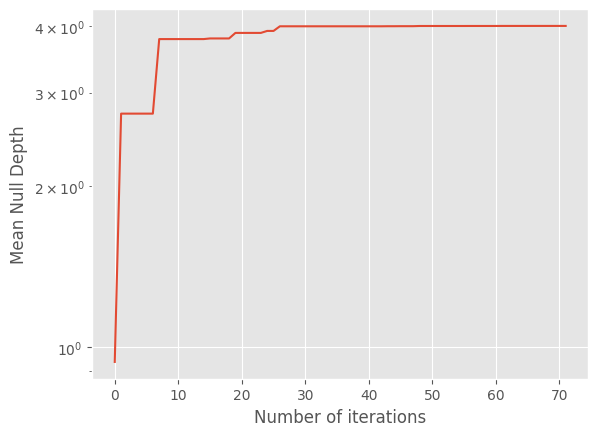

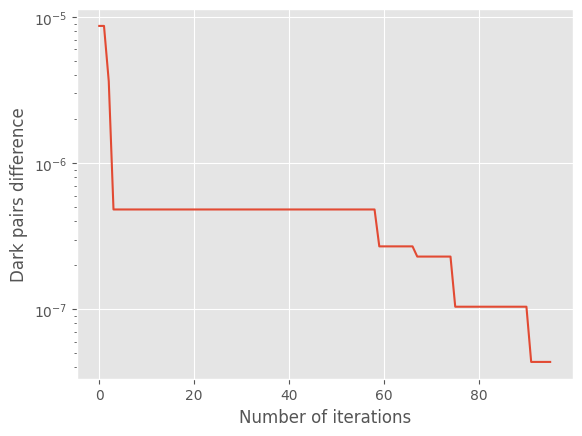

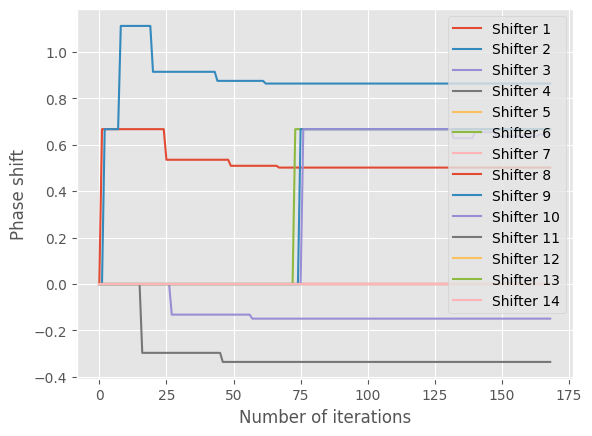

Optimized parameters | Introduced error
P1 = 0.00e+00 | 0.00e+00
P2 = 3.62e-01 | 1.64e+00
P3 = -6.50e-01 | 1.62e-01
P4 = -8.37e-01 | 3.51e-01
P5 = -5.01e-01 | 1.13e+00
P6 = 1.65e-01 | 3.85e-01
P7 = -5.01e-01 | 1.62e+00
P8 = -5.01e-01 | 1.42e+00
P9 = 1.65e-01 | 9.29e-01
P10 = 1.43e-01 | 1.18e+00
P11 = -5.01e-01 | 1.83e+00
P12 = -5.01e-01 | 2.70e-01
P13 = -5.01e-01 | 5.00e-01
P14 = -5.01e-01 | 9.80e-01


In [9]:
optimized_parameters = kn0.shift_powers
optimized_parameters, bright_evol, dark_symmetry_evol, shifts_evol = utils.optimize(kn0, star_light, verbose=False)

plt.figure()
plt.plot(bright_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(dark_symmetry_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure()
for i in range(len(kn0.shift_powers)):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend()
plt.show()

# Ignoring global phase
introduced_error = kn0.shifters_noise + kn0.shifters_offset
introduced_error -= introduced_error[0]
optimized_parameters -= optimized_parameters[0]
optimized_parameters = utils.bound_phase(optimized_parameters)

print("Optimized parameters | Introduced error")
for i in range(14):
    print(f"P{i+1} = {optimized_parameters[i]:.2e} | {introduced_error[i]:.2e}")

# Parameter impact

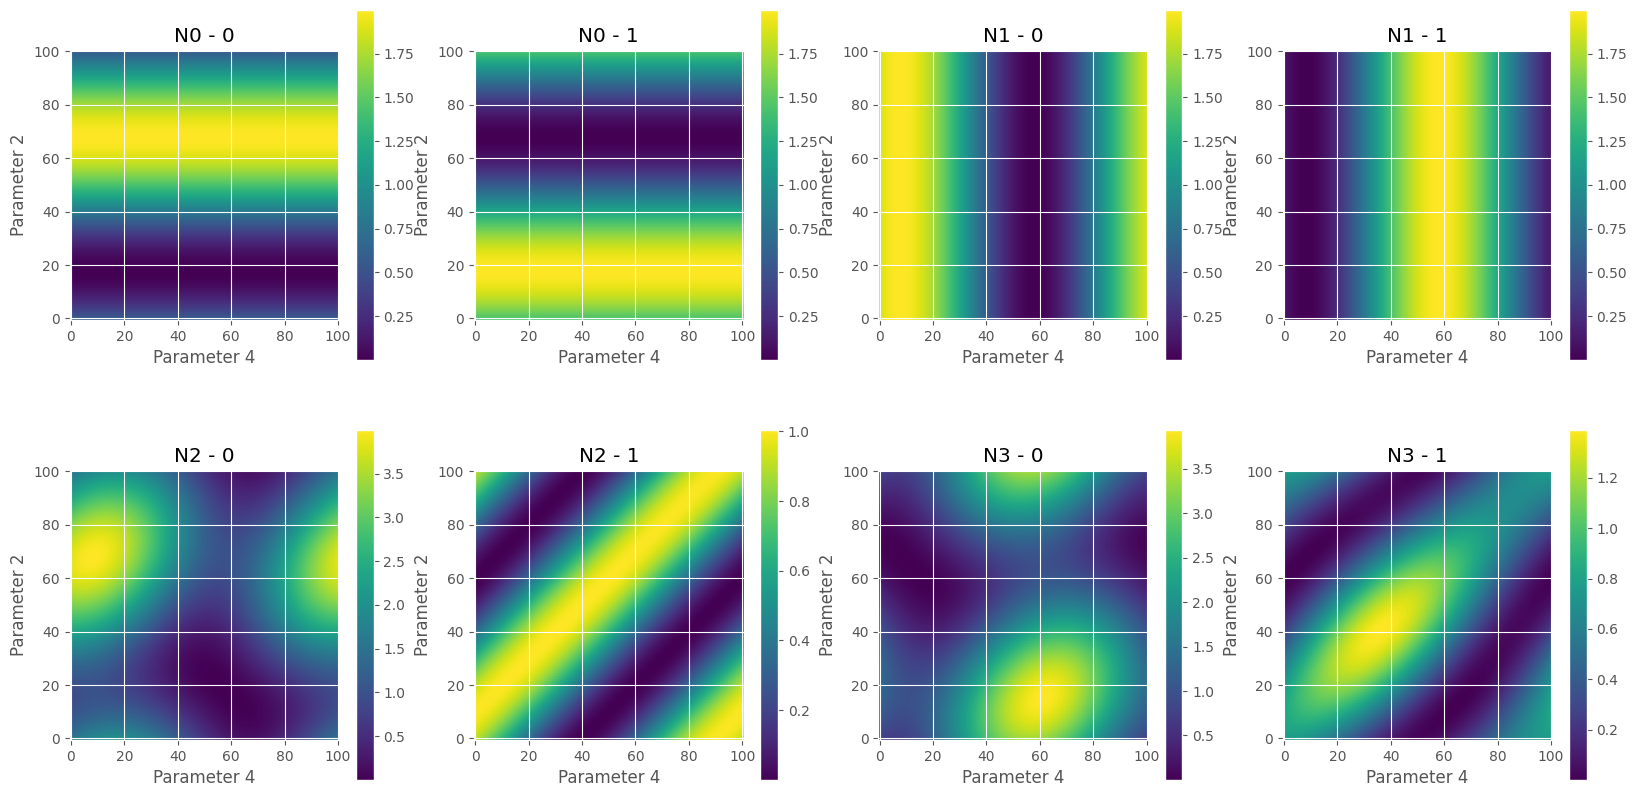

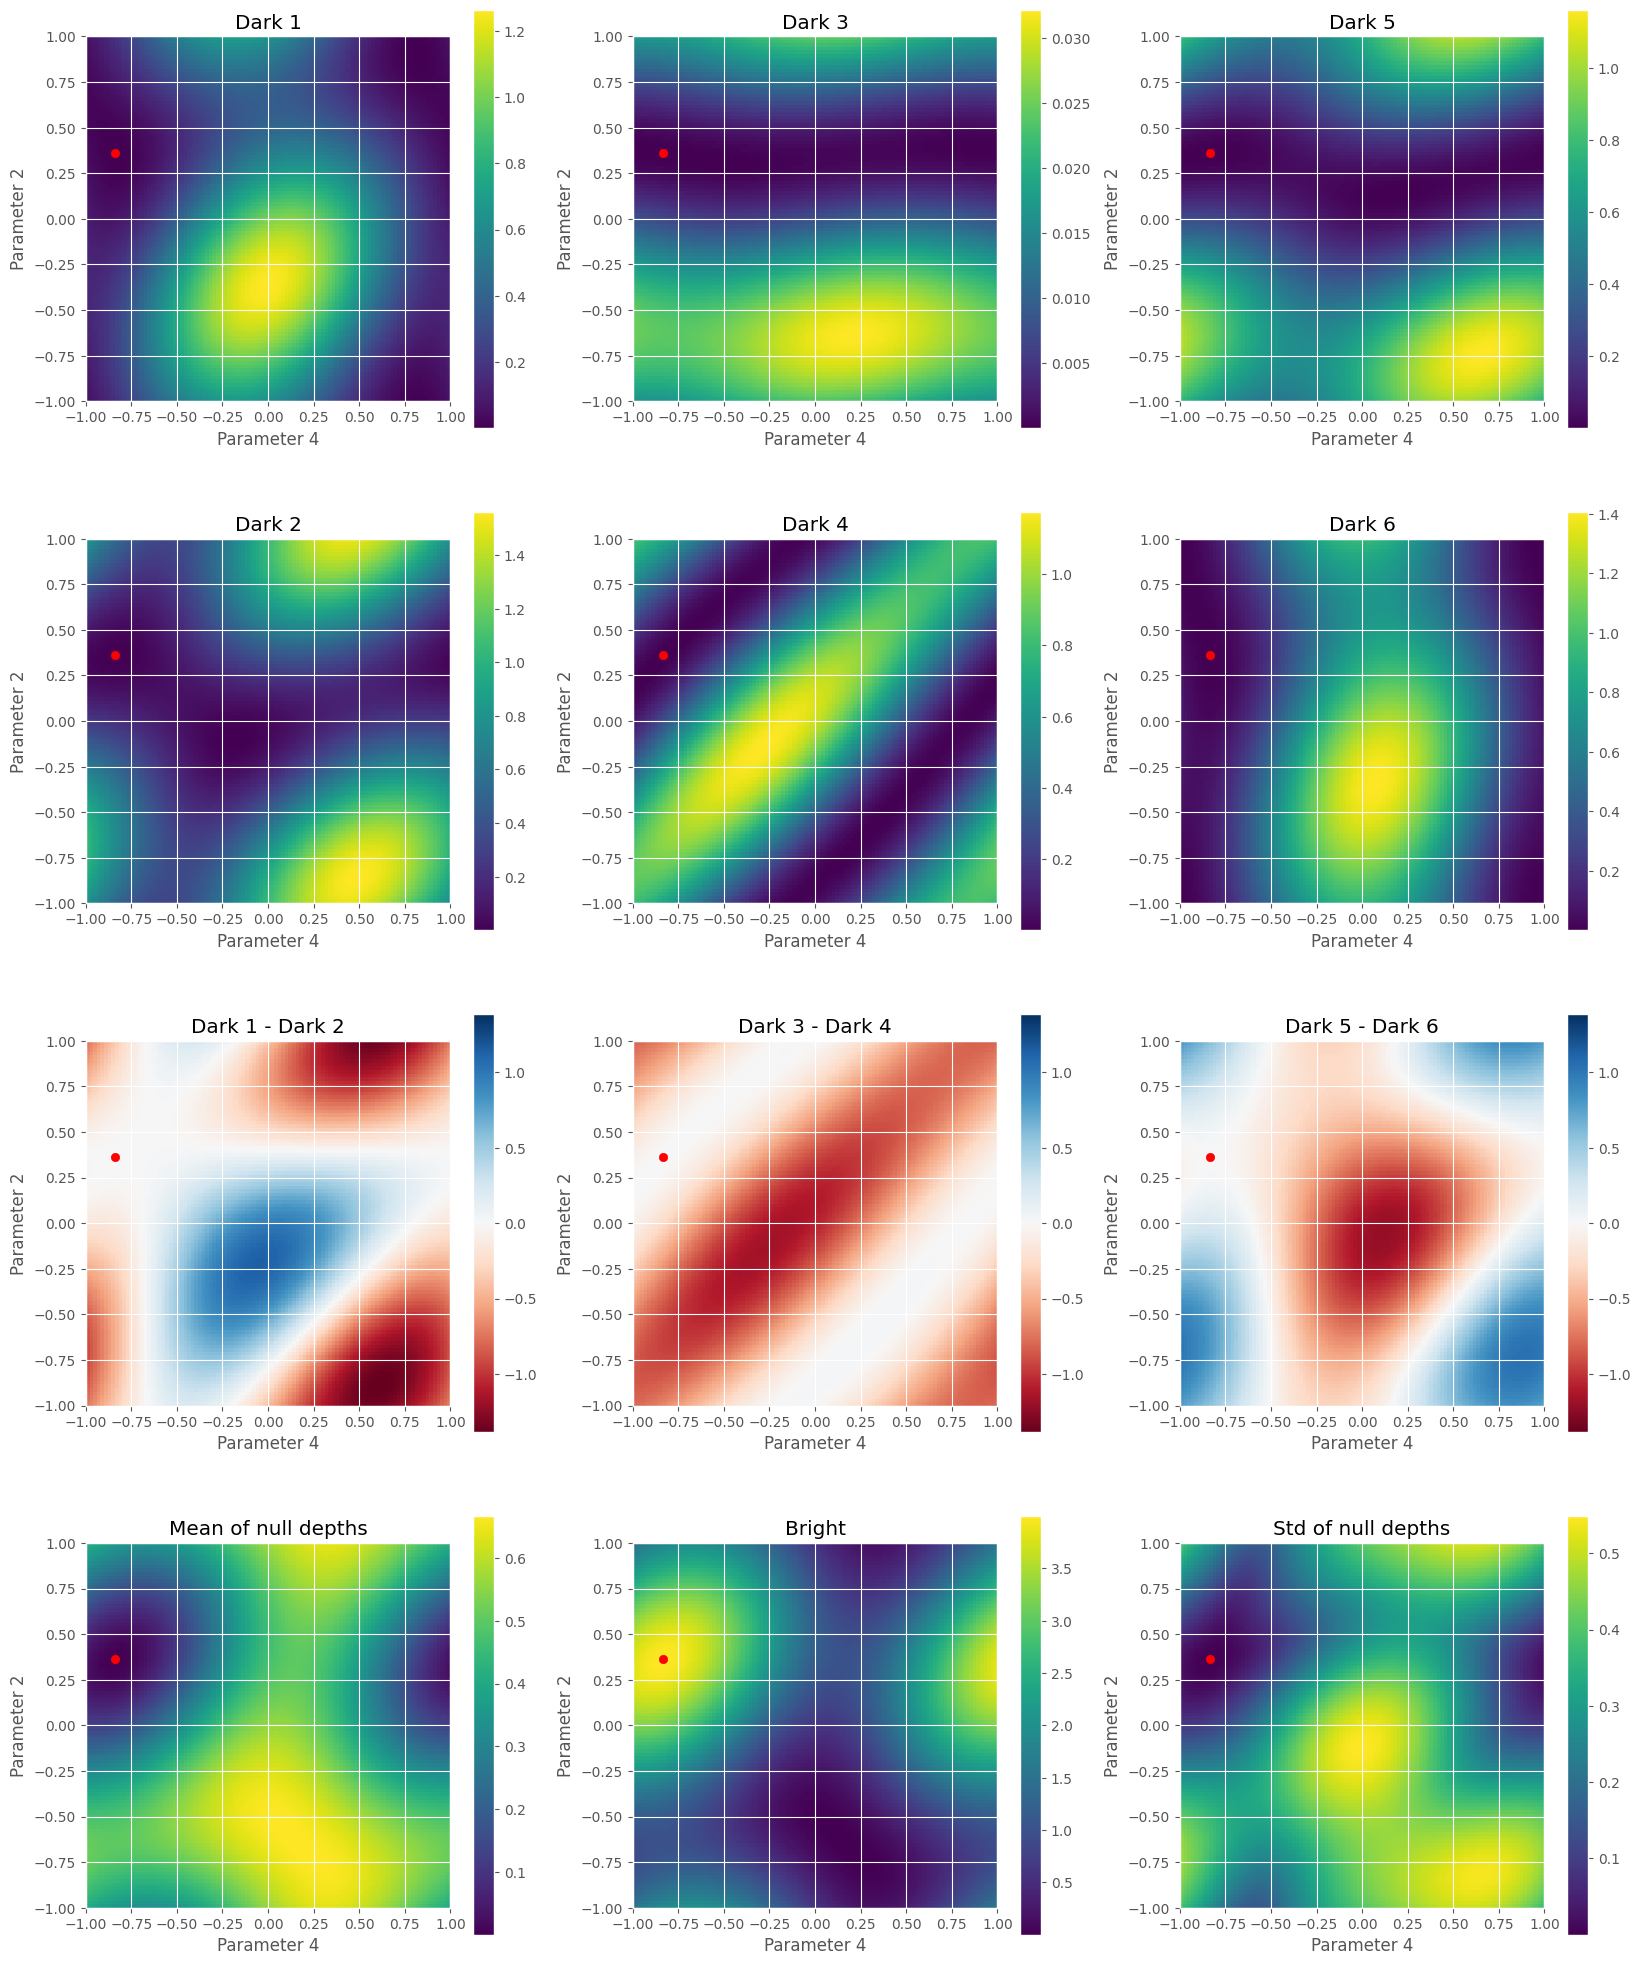

In [10]:
utils.scan(
    kn=kn0, 
    beams=star_light,
    scan_on=(2,4),
    initial_parameters=optimized_parameters,
    optimized_parameters=optimized_parameters,
    plot_intermediate_states=True
)